In [26]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [62]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.

In [63]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [64]:
zdim = 32


def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("LeakyReLU")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("LeakyReLU")(x)

    return x

In [65]:
encoder_input = Input((28, 28, 1))

x = conv2d_block(encoder_input, 28)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.1)(x)

x = conv2d_block(x, 64)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.1)(x)

x = conv2d_block(x, 128)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.1)(x)

x = Flatten()(x)

x = Dense(128)(x)
x = LeakyReLU(0.2)(x)
x = Dense(64)(x)
x = LeakyReLU(0.2)(x)
x = Dense(12)(x)
x = LeakyReLU(0.2)(x)

encoder_output = Dense(zdim)(x)

model_encoder = Model(encoder_input, encoder_output)
model_encoder.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 28)        280       
_________________________________________________________________
batch_normalization_59 (Batc (None, 28, 28, 28)        112       
_________________________________________________________________
activation_58 (Activation)   (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 28)        7084      
_________________________________________________________________
batch_normalization_60 (Batc (None, 28, 28, 28)        112       
_________________________________________________________________
activation_59 (Activation)   (None, 28, 28, 28)        0  

In [80]:
decoder_input = Input(shape=(zdim, ))

x = Dense(256)(decoder_input)
x = LeakyReLU(0.2)(x)
x = Dense(1568)(x)

x = Reshape((7, 7, 32))(x)

x = Conv2DTranspose(32, 2, 2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)

x = Conv2DTranspose(1, 2, 2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("LeakyReLU")(x)

decoder_output = x

model_decoder = Model(decoder_input, decoder_output)
model_decoder.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)               8448      
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1568)              402976    
_________________________________________________________________
reshape_20 (Reshape)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_73 (Conv2DT (None, 14, 14, 32)        4128      
_________________________________________________________________
batch_normalization_77 (Batc (None, 14, 14, 32)        128

In [81]:
model_input = encoder_input
model_output = model_decoder(encoder_output)

model = Model(model_input, model_output)
model.compile(optimizer='adam', loss='mse')

In [82]:
model.fit(x_train,
          x_train,
          epochs=3,
          batch_size=64,
          shuffle=True,
          validation_data=(x_test, x_test))

Epoch 1/3
938/938 [==============================] - 9s 8ms/step - loss: 0.0538 - val_loss: 1720.1754
Epoch 2/3
938/938 [==============================] - 7s 8ms/step - loss: 0.0180 - val_loss: 1401.8489
Epoch 3/3
938/938 [==============================] - 7s 8ms/step - loss: 0.0156 - val_loss: 1160.5806


In [83]:
decoded_img = model.predict(x_test)

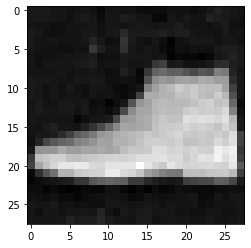

In [84]:
plt.imshow(decoded_img[0].reshape(28, 28), cmap='gray')

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 28, 28, 1)]       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


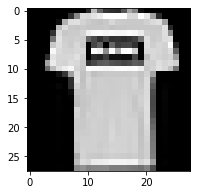

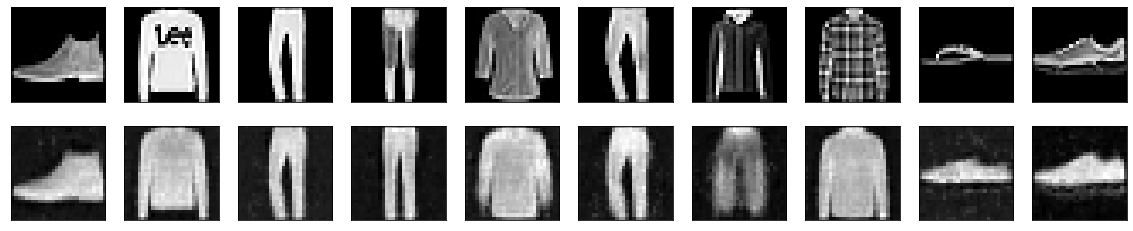

In [96]:
get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]

plt.figure(figsize=(15, 3))
visual_model = tf.keras.models.Model(inputs=model.input, outputs=get_output[0])
visual_model.summary()

plt.imshow(x_train[1], cmap='gray')

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_img[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.show()